Reading the papers on [Pathway Assembly](https://arxiv.org/pdf/1907.04649.pdf), [Assembly Theory](https://arxiv.org/pdf/2206.02279.pdf) and going through the code found at [Paper-AssemblyTreeOfLife](https://github.com/croningp/Paper-AssemblyTreeOfLife), I was wondering if we could find a generalized algorithm for decomposing structures into an Assembly Tree using graphs.

The following is a personal attempt in trying to wrap my head around this fascinating topic.

First we set up the dependencies:

In [53]:
import networkx as nx # used for working with graphs
import numpy as np # used for working with adjecency matrices etc.
import matplotlib.pyplot as plt # used for plotting

For this example we'll use the 1 dimensional case of a string "abracadabra" as used in the paper.
We index it so that similarly labeled characters are still represented as individual nodes.

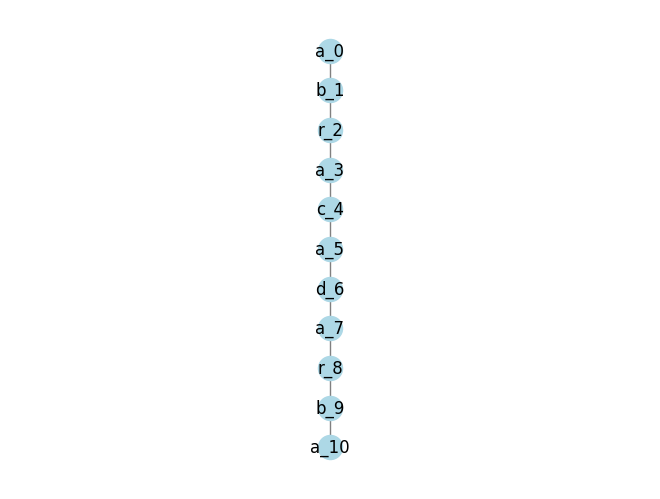

In [54]:
G = nx.Graph()

example_string = "abracadabra"
example_array = list(example_string)

example_array_indexed = [f"{example_array[i]}_{i}" for i in range(len(example_array))]

# Add nodes
for node in example_array_indexed:
    G.add_node(node)

# Connect nodes sequentially
for i in range(len(example_array_indexed) - 1):
    G.add_edge(example_array_indexed[i], example_array_indexed[i+1])

pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

Since we can perform calculations using letters we will encode them numerically.
As an encoding I chose to represent them as evenly spaced intervals between 0 and 1 both not included.

One of the main reasons I think a graph representation is particularly useful is that we can easily get its adjecency matrix which represents the connections between the nodes.
The adjecency matrix just by itself however does not contain information about the nodes e.g. their labels. By using our relabeling vector and placing our numerical encodings on the diagonal of an identity matrix we can then add it to the adjecency matrix.
By doing this we get a matrix containing both edge information and the labels of the nodes.

In [55]:
def relabel_string(string):
    unique_chars = set(string)
    n = len(unique_chars)

    # Create a dictionary to map each character to its new label
    label_mapping = {char: (i+1) * (1/(n+1)) for i, char in enumerate(unique_chars)}

    # Relabel the characters in the string based on the mapping
    relabeled_string = [label_mapping[char] for char in string]

    return relabeled_string, label_mapping

relabeling, mapping = relabel_string(example_string)
labels_G1 = np.diag(relabeling)
G_adj = nx.to_numpy_array(G)

G_adj_relabel = G_adj + labels_G1

print(G_adj_relabel, mapping)

[[0.5        1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [1.         0.83333333 1.         0.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         1.         0.66666667 1.         0.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         1.         0.5        1.         0.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.16666667 1.
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.5
  1.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.33333333 1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.5        1.         0.         0.        ]
 [0.         0.         0.         0.         0.       

Using this labeled adjecency matrix we can start to figure out its assembly path. The obvious technique for strings is to look for substrings. The longer the better since they might subdivide as well.
One strategy might be to favour even sized substrings over odd sized ones since even substrings have the chance of further subdivision.

In the case of "abracadabra" we have 11 characters. In the simple case of a string the longest path becomes the length of the string.
The longest possible subunit therefore becomes => 11 // 2 = 5, which is what will look for in the first pass.
In consequent passes we might look for smaller repeating (non-overlapping) subunits.

For different dimensional graphs this problem becomes more computationally complex.

In [56]:
def floyd_warshall_with_path_reconstruction(adj_matrix):
    n = len(adj_matrix)
    dist_matrix = np.copy(adj_matrix)
    next_node = np.zeros(adj_matrix.shape, dtype=int)

    # Initialize distance and next matrices
    for i in range(n):
        for j in range(n):
            if i != j and adj_matrix[i][j] == 0:
                dist_matrix[i][j] = np.inf
            else:
                next_node[i][j] = j

    # Floyd-Warshall with path reconstruction
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist_matrix[i][k] + dist_matrix[k][j] < dist_matrix[i][j]:
                    dist_matrix[i][j] = dist_matrix[i][k] + dist_matrix[k][j]
                    next_node[i][j] = next_node[i][k]

    return dist_matrix, next_node

def reconstruct_path(start, end, next_node):
    if next_node[start][end] == 0:
        return []

    path = [start]
    while start != end:
        start = next_node[start][end]
        path.append(start)

    return path

dist_matrix, next_node_matrix = floyd_warshall_with_path_reconstruction(G_adj_relabel)

dist_matrix[dist_matrix == np.inf] = -1

# Find the maximum distance and corresponding node pair
max_distance = np.max(dist_matrix)
furthest_nodes = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)


# Reconstructing the path between the furthest nodes
path = reconstruct_path(furthest_nodes[0], furthest_nodes[1], next_node_matrix)
print(path)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In order to find all possible subgraphs along the longest path we use a sliding window.

In [57]:
def find_non_overlapping_subarrays(arr, n):
    subarrays = []
    length = len(arr)

    # Iterate over the array to create subarrays
    for i in range(length - n + 1):
        for j in range(i + n, length - n + 1):
            subarrays.append((arr[i:i+n], arr[j:j+n]))

    return subarrays



Using all possible non-overlapping subgraphs we than grab the submatrices for these subgraphs.
This way we also cleanly break any connections they might have with other nodes in the larger graph.

By comparing their spectra we know its the same subunit. 
We can also just do a quick compare but if the subunit has undergone a transformation it wouldn't show.
Using spectra we can see that they might be the same. (We can still have spectra colusion so we might need to do more checking.)

In [58]:
def submatrix(matrix, indices):
    return matrix[np.ix_(indices, indices)]

def spectrum(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.sort(eigenvalues)

def compare_spectra(spectrum1, spectrum2):
    return np.allclose(spectrum1, spectrum2, rtol=0.00001)

def find_subunits(adjecency_matrix, path):
    for n in range(len(path) // 2, 0, -1):
        subarrays = find_non_overlapping_subarrays(path, n)
        for subarray in subarrays:
            submatrix1 = submatrix(adjecency_matrix, subarray[0])
            submatrix2 = submatrix(adjecency_matrix, subarray[1])

            spectrum1 = spectrum(submatrix1)
            spectrum2 = spectrum(submatrix2)

            if compare_spectra(spectrum1, spectrum2):
                return subarray
            
subs = find_subunits(G_adj_relabel, path)
print(subs)

([0, 1, 2, 3], [7, 8, 9, 10])


Now that we have found a repeating subunit we have a first possible level in our assembly tree.